<a href="https://colab.research.google.com/github/KrShresth/Tweet-Spam-Detection-Using-Machine-Learning-Randomforest-and-Swarm-Optimization-Techniques/blob/main/Tweet_Spam_Detection_RF_WOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords

nltk.download('stopwords')
df = pd.read_csv('/content/drive/MyDrive/project/data_train.csv')
df.shape
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Id,Tweet,following,followers,actions,is_retweet,location,Type
0,10091,It's the everything else that's complicated. #...,0.0,11500.0,NaN,0.0,Chicago,Quality
1,10172,Eren sent a glare towards Mikasa then nodded a...,0.0,0.0,NaN,0.0,NaN,Quality
2,7012,I posted a new photo to Facebook http://fb.me/...,0.0,0.0,NaN,0.0,"Scotland, U.K",Quality
3,3697,#jan Idiot Chelsea Handler Diagnoses Trump Wit...,3319.0,611.0,294.0,0.0,FBBIGBANG&2NE1TH,Spam
4,10740,Pedophile Anthony Weiner is TERRIFIED of Getti...,4840.0,1724.0,1522.0,0.0,www.instagram.com/fender,Spam


In [4]:
# Make consistent lowercase column names
df.columns = df.columns.str.lower()

# Remove duplicates
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]

print("Duplicates removed:", before - after)
print("Shape after removing duplicates:", df.shape)

# Show class distribution
print("\nClass distribution:")
print(df['type'].value_counts())

df.head()


Duplicates removed: 0
Shape after removing duplicates: (11968, 8)

Class distribution:
type
Quality    6153
Spam       5815
Name: count, dtype: int64


,id,tweet,following,followers,actions,is_retweet,location,type
0,10091,It's the everything else that's complicated. #...,0.0,11500.0,NaN,0.0,Chicago,Quality
1,10172,Eren sent a glare towards Mikasa then nodded a...,0.0,0.0,NaN,0.0,NaN,Quality
2,7012,I posted a new photo to Facebook http://fb.me/...,0.0,0.0,NaN,0.0,"Scotland, U.K",Quality
3,3697,#jan Idiot Chelsea Handler Diagnoses Trump Wit...,3319.0,611.0,294.0,0.0,FBBIGBANG&2NE1TH,Spam
4,10740,Pedophile Anthony Weiner is TERRIFIED of Getti...,4840.0,1724.0,1522.0,0.0,www.instagram.com/fender,Spam


In [5]:
# Safe fill NaN in tweet column
df["tweet"] = df["tweet"].astype(str)

# Create metadata features
df["text_length"] = df["tweet"].apply(lambda x: len(x))
df["word_count"] = df["tweet"].apply(lambda x: len(x.split()))
df["has_link"] = df["tweet"].apply(lambda x: 1 if "http" in x or "www" in x else 0)
df["has_mention"] = df["tweet"].apply(lambda x: 1 if "@" in x else 0)
df["hashtags_count"] = df["tweet"].apply(lambda x: x.count("#"))
df["is_retweet_flag"] = df["is_retweet"].fillna(0).apply(lambda x: 1 if x == 1 else 0)

# Preview
df.head()


,id,tweet,following,followers,actions,is_retweet,location,type,text_length,word_count,has_link,has_mention,hashtags_count,is_retweet_flag
0,10091,It's the everything else that's complicated. #...,0.0,11500.0,NaN,0.0,Chicago,Quality,84,8,0,0,2,0
1,10172,Eren sent a glare towards Mikasa then nodded a...,0.0,0.0,NaN,0.0,NaN,Quality,139,24,0,1,0,0
2,7012,I posted a new photo to Facebook http://fb.me/...,0.0,0.0,NaN,0.0,"Scotland, U.K",Quality,55,8,1,0,0,0
3,3697,#jan Idiot Chelsea Handler Diagnoses Trump Wit...,3319.0,611.0,294.0,0.0,FBBIGBANG&2NE1TH,Spam,105,11,1,0,1,0
4,10740,Pedophile Anthony Weiner is TERRIFIED of Getti...,4840.0,1724.0,1522.0,0.0,www.instagram.com/fender,Spam,92,12,1,0,0,0


In [6]:
import re
import string
stop_words = set(stopwords.words("english"))


def clean_tweet(text):
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Remove mentions
    text = re.sub(r"@\w+", "", text)

    # Remove hashtags (keep the word)
    text = re.sub(r"#", "", text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    # Remove stopwords
    words = [w for w in text.split() if w not in stop_words]

    return " ".join(words)

df["clean_text"] = df["tweet"].apply(clean_tweet)

df[["tweet", "clean_text"]].head()


,tweet,clean_text
0,It's the everything else that's complicated. #...,everything else thats complicated pesummit pxp...
1,Eren sent a glare towards Mikasa then nodded a...,eren sent glare towards mikasa nodded stood go...
2,I posted a new photo to Facebook http://fb.me/...,posted new photo facebook
3,#jan Idiot Chelsea Handler Diagnoses Trump Wit...,jan idiot chelsea handler diagnoses trump disease
4,Pedophile Anthony Weiner is TERRIFIED of Getti...,pedophile anthony weiner terrified getting bea...


In [7]:
from sklearn.model_selection import train_test_split

# Encode target manually: Quality=0, Spam=1
df["label"] = df["type"].apply(lambda x: 1 if x == "Spam" else 0)

# Select features
X = df[[
    "clean_text",
    "text_length",
    "word_count",
    "has_link",
    "has_mention",
    "hashtags_count",
    "is_retweet_flag"
]]

y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " | Spam count:", y_train.sum())
print("Test shape:", X_test.shape, "  | Spam count:", y_test.sum())

X_train.head()


Train shape: (9574, 7)  | Spam count: 4652
Test shape: (2394, 7)   | Spam count: 1163


,clean_text,text_length,word_count,has_link,has_mention,hashtags_count,is_retweet_flag
11429,dairy awful cramps,25,5,0,0,0,1
3520,boy mother found dead manhattan apartment nypd,99,10,1,0,0,0
4597,united saga goes,31,7,0,0,0,0
1782,mt sentiments exactly wakeupamerica tcot cospr...,124,12,1,1,5,1
5897,us judge sticks nose states rights issue,70,9,1,0,0,1


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,       # enough for tweets
    ngram_range=(1,2),       # unigrams + bigrams
    min_df=2                 # remove rare words
)

# Fit only on training data
X_train_tfidf = tfidf.fit_transform(X_train["clean_text"])

# Transform test data using the same vectorizer
X_test_tfidf = tfidf.transform(X_test["clean_text"])

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)


TF-IDF train shape: (9574, 5000)
TF-IDF test shape: (2394, 5000)


In [9]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns
num_cols = [
    "text_length", "word_count", "has_link",
    "has_mention", "hashtags_count", "is_retweet_flag"
]

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only
X_train_num = scaler.fit_transform(X_train[num_cols])

# Transform test data using the same scaler
X_test_num = scaler.transform(X_test[num_cols])

print("Numeric train shape:", X_train_num.shape)
print("Numeric test shape:", X_test_num.shape)


Numeric train shape: (9574, 6)
Numeric test shape: (2394, 6)


In [10]:
from scipy.sparse import hstack, csr_matrix

# Convert numeric features to sparse format
X_train_num_sparse = csr_matrix(X_train_num)
X_test_num_sparse = csr_matrix(X_test_num)

# Combine TF-IDF + numeric features
X_train_final = hstack([X_train_tfidf, X_train_num_sparse])
X_test_final = hstack([X_test_tfidf, X_test_num_sparse])

print("Final train shape:", X_train_final.shape)
print("Final test shape:", X_test_final.shape)


Final train shape: (9574, 5006)
Final test shape: (2394, 5006)


In [11]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

X_train_bal, y_train_bal = ros.fit_resample(X_train_final, y_train)

print("Before oversampling:", np.bincount(y_train))
print("After oversampling :", np.bincount(y_train_bal))


Before oversampling: [4922 4652]
After oversampling : [4922 4922]


In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_bal, y_train_bal)

# Predict on test set
rf_pred = rf.predict(X_test_final)

print("Random Forest training complete!")


Random Forest training complete!


=== RANDOM FOREST PERFORMANCE ===

              precision    recall  f1-score   support

           0     0.9034    0.9196    0.9114      1231
           1     0.9132    0.8960    0.9045      1163

    accuracy                         0.9081      2394
   macro avg     0.9083    0.9078    0.9080      2394
weighted avg     0.9082    0.9081    0.9081      2394



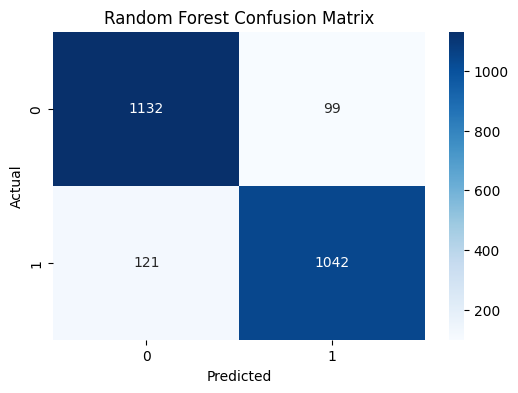

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("=== RANDOM FOREST PERFORMANCE ===\n")
print(classification_report(y_test, rf_pred, digits=4))

cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

base = DecisionTreeClassifier(
    max_depth=2,
    class_weight="balanced"
)

ada = AdaBoostClassifier(
    estimator=base,
    n_estimators=300,
    learning_rate=0.5,
    random_state=42
)

ada.fit(X_train_bal, y_train_bal)

ada_pred = ada.predict(X_test_final)

print("AdaBoost training complete!")

AdaBoost training complete!


=== ADA BOOST PERFORMANCE ===

              precision    recall  f1-score   support

           0     0.8749    0.8180    0.8455      1231
           1     0.8198    0.8762    0.8470      1163

    accuracy                         0.8463      2394
   macro avg     0.8473    0.8471    0.8463      2394
weighted avg     0.8481    0.8463    0.8463      2394



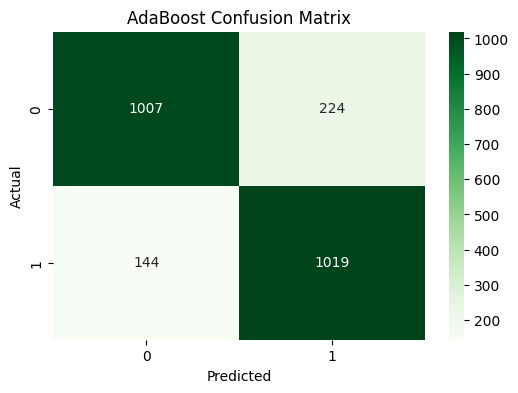

In [15]:
print("=== ADA BOOST PERFORMANCE ===\n")
print(classification_report(y_test, ada_pred, digits=4))

cm = confusion_matrix(y_test, ada_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("AdaBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [17]:
import random
import numpy as np

def woa_optimize(iterations=10, whales=8):
    best_score = 0
    best_params = {}

    print("Starting WOA optimization...\n")

    for t in range(iterations):
        print(f"Iteration {t+1}/{iterations}")

        for w in range(whales):

            lr = round(random.uniform(0.1, 1.0), 3)
            est = random.randint(150, 500)

            # Build model
            model = AdaBoostClassifier(
                estimator=DecisionTreeClassifier(
                    max_depth=2, class_weight="balanced"
                ),
                n_estimators=est,
                learning_rate=lr,
                random_state=42
            )

            # Train
            model.fit(X_train_bal, y_train_bal)

            # Evaluate on validation (we use test for now because test split already done)
            score = model.score(X_test_final, y_test)

            # Update best
            if score > best_score:
                best_score = score
                best_params = {"lr": lr, "estimators": est}

        print(f"  Best so far \u2192 Score: {best_score:.4f}, Params: {best_params}\n")

    return best_params, best_score


best_params, best_score = woa_optimize()
print("\nFinal BEST parameters found:")
print(best_params)
print("Best accuracy:", best_score)

Starting WOA optimization...

Iteration 1/10
  Best so far → Score: 0.8542, Params: {'lr': 0.728, 'estimators': 468}

Iteration 2/10
  Best so far → Score: 0.8571, Params: {'lr': 0.987, 'estimators': 441}

Iteration 3/10
  Best so far → Score: 0.8571, Params: {'lr': 0.987, 'estimators': 441}

Iteration 4/10
  Best so far → Score: 0.8571, Params: {'lr': 0.987, 'estimators': 441}

Iteration 5/10
  Best so far → Score: 0.8571, Params: {'lr': 0.987, 'estimators': 441}

Iteration 6/10
  Best so far → Score: 0.8571, Params: {'lr': 0.987, 'estimators': 441}

Iteration 7/10
  Best so far → Score: 0.8588, Params: {'lr': 0.889, 'estimators': 250}

Iteration 8/10
  Best so far → Score: 0.8588, Params: {'lr': 0.889, 'estimators': 250}

Iteration 9/10
  Best so far → Score: 0.8588, Params: {'lr': 0.889, 'estimators': 250}

Iteration 10/10
  Best so far → Score: 0.8588, Params: {'lr': 0.889, 'estimators': 250}


Final BEST parameters found:
{'lr': 0.889, 'estimators': 250}
Best accuracy: 0.858813700

In [19]:
best_lr = 0.889
best_estimators = 250

ada_woa = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2, class_weight="balanced"),
    n_estimators=best_estimators,
    learning_rate=best_lr,
    random_state=42
)

ada_woa.fit(X_train_bal, y_train_bal)

ada_woa_pred = ada_woa.predict(X_test_final)

print("WOA-AdaBoost training complete!")

WOA-AdaBoost training complete!


=== WOA + ADA BOOST PERFORMANCE ===

              precision    recall  f1-score   support

           0     0.8787    0.8416    0.8598      1231
           1     0.8395    0.8770    0.8579      1163

    accuracy                         0.8588      2394
   macro avg     0.8591    0.8593    0.8588      2394
weighted avg     0.8597    0.8588    0.8588      2394



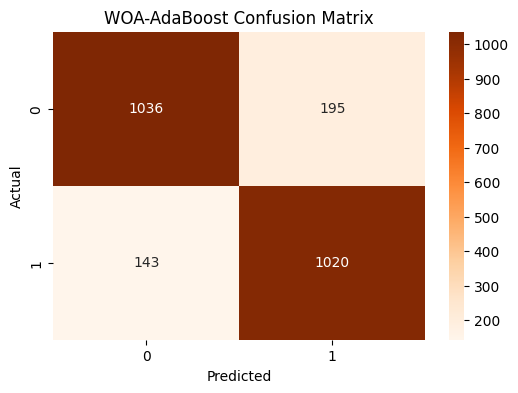

In [20]:
print("=== WOA + ADA BOOST PERFORMANCE ===\n")
print(classification_report(y_test, ada_woa_pred, digits=4))

cm = confusion_matrix(y_test, ada_woa_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("WOA-AdaBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [21]:
import pickle

# Save Random Forest (best model)
with open("model_random_forest.pkl", "wb") as f:
    pickle.dump(rf, f)

# Save WOA-AdaBoost
with open("model_ada_woa.pkl", "wb") as f:
    pickle.dump(ada_woa, f)

# Save TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# Save scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("All models and transformers saved successfully!")


All models and transformers saved successfully!
